# Clifford/XEB/Layer Fidelity

Use layer fidelity to place a chain and then measure a full Clifford circuit. Flag to also measure a Haar random version of the circuit and perform XEB.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import pickle
from shutil import copy2

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, EstimatorV2

import qiskit_device_benchmarking.utilities.layer_fidelity_utils as lfu
import qiskit_device_benchmarking.utilities.file_utils as fu
import qiskit_device_benchmarking.utilities.cliffordize_utils as cu

# for simulating
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

## Load Backend and Options

In [2]:
# load service
accnt_name = "my_accnt"
service = QiskitRuntimeService(name=accnt_name)

In [3]:
# Specify machine
machine = "ibm_fez"
hgp = ""

# Get backend
backend = service.backend(machine, instance=hgp)
coupling_map = backend.coupling_map

# Get two qubit gate
if "ecr" in backend.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend.configuration().basis_gates:
    twoq_gate = "cz"
else:
    twoq_gate = "cx"

# Get one qubit basis gates
oneq_gates = []
for i in backend.configuration().basis_gates:
    # put in a case to handle rx and rzz
    if i.casefold() == "rx" or i.casefold() == "rzz":
        continue
    if i.casefold() != twoq_gate.casefold():
        oneq_gates.append(i)

run_sim = False

if run_sim:
    print("Running in Sim Mode")

    twoq_gate = "cz"
    basis_gates = [twoq_gate, "sx", "x", "rz"]

    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(0.0001, 1)
    noise_model.add_all_qubit_quantum_error(error, ["sx", "x"])

    re_err = np.random.random(15) / 50
    for j, i in enumerate(re_err):
        re = ReadoutError([[1 - i, i], [i, 1 - i]])
        # noise_model.add_readout_error(re, [j])

    error = depolarizing_error(0.002, 2)
    noise_model.add_all_qubit_quantum_error(error, ["cz"])

    # Print noise model info
    print(noise_model)

    backend = AerSimulator(
        coupling_map=[[i, i + 1] for i in range(15)],
        basis_gates=basis_gates,
        noise_model=noise_model,
    )
    coupling_map = backend.coupling_map

In [4]:
# Settings for the Clifford/XEB Run

# number of qubits in the chain
nqubits = [8, 12]

# number of layers
nlayers = [4, 8, 12, 16, 20, 24, 28]

# Options for the runs
# Here we will randomize the pauli with the
# Cliffordization so only need to specify ones
ncliffordizations = 50

# shots per cliffordization separated into the number of qubits
cliff_shots = [1000, 1000]

if len(cliff_shots) != len(nqubits):
    raise ValueError("shots array and qubits array need to be identical length")

# number of randomizations for the haar circuits
haarsamples = 20
haar_shots = 1000
haar_twirls = 1

# shots for the chain finding
eplg_spam_shots = 200

# do XEB
run_xeb = True

# do we want to analyze the XEB data
# note: this will fail if it's too large
analyze_xeb = True

if analyze_xeb and nqubits[-1] > 20:
    print("Warning, analyzing XEB for more than 20 qubits will be quite slow")

# save bindings
save_bindings = False
file_name_root = fu.timestamp_name()

if save_bindings:
    os.makedirs(file_name_root, exist_ok=True)
    print(f"Directory '{file_name_root}' ensured to exist.")

# Prepare samplers/estimators for the runs

# use this for the cliffordization
estimator = EstimatorV2(backend)
estimator.options.resilience_level = 0
estimator.options.twirling.enable_gates = True
estimator.options.twirling.enable_measure = True
estimator.options.resilience.measure_mitigation = False
estimator.options.twirling.num_randomizations = 1
estimator.options.twirling.shots_per_randomization = cliff_shots[0]

# use this for the XEB
sampler_twirled = SamplerV2(backend)
sampler_twirled.options.twirling.enable_gates = True
sampler_twirled.options.twirling.enable_measure = True
sampler_twirled.options.default_shots = haar_shots
sampler_twirled.options.twirling.num_randomizations = haar_twirls
sampler_twirled.options.twirling.shots_per_randomization = int(haar_shots / haar_twirls)

# get the grid chains
if not run_sim:
    grid_chain_flt, layers = lfu.grid_chain_to_layers(backend, coupling_map)

Decomposing grid chain into disjoint layers


## Generate Bindings

Generate the circuit parameters for the different clifford and haar datasets. Need to run once.

In [5]:
%%time
cliff_list = []
haar_list = []


for nq in nqubits:
    cliff_list.append([])
    haar_list.append([])
    for nl in nlayers:
        print([nq, nl])

        target_circ = cu.bricklayer_circ(nq, nl, gate=twoq_gate)
        cliff_tmp = cu.Cliffordize(target_circ, ncliffordizations)
        _, _, _ = cliff_tmp.random_cliff()
        cliff_list[-1].append(cliff_tmp)

        if run_xeb:
            cliff_tmp = cu.Cliffordize(target_circ, haarsamples)
            _,_ = cliff_tmp.random_haar()
            haar_list[-1].append(cliff_tmp)


if save_bindings:
    with open(os.path.join(file_name_root, "cliff_objs.pkl"), "wb") as file:
        pickle.dump(cliff_list, file)

    if run_xeb:
        with open(os.path.join(file_name_root, "haar_objs.pkl"), "wb") as file:
            pickle.dump(haar_list, file)

    #save a copy of this notebook
    copy2("clifford_xeb_lf.ipynb",os.path.join(file_name_root, "copy_cliff_xeb_lf.ipyb"))

[8, 4]
[8, 8]
[8, 12]
[8, 16]
[8, 20]
[8, 24]
[8, 28]
[12, 4]
[12, 8]
[12, 12]
[12, 16]
[12, 20]
[12, 24]
[12, 28]
CPU times: user 15.9 s, sys: 1.01 s, total: 16.9 s
Wall time: 16.1 s


## Run the Experiment

First, run a set of grid RB (LF) runs and SPAM circuits to find the best chains. Once we find the best chains, run the Cliffordization

In [49]:
cliff_ids = []
haar_ids = []
chain_lst = []
eplg_lst = []
cliff_jobs = []
haar_jobs = []

spam_id = 0
eplg_ids = 0

if not run_sim:
    # run the eplg + spam circuits
    print("Launching EPLG + SPAM circuits")
    lfexps, eplg_ids, spam_id = cu.run_eplg_and_spam(
        grid_chain_flt, layers, backend, twoq_gate, oneq_gates
    )

    # analyze the circuits
    print("Analyzing EPLG + SPAM circuits (waiting in queue)")
    err_dict = cu.eplg_analysis(lfexps, eplg_ids, service, backend, twoq_gate, layers)
    readout_fids = cu.spam_analysis(backend.num_qubits, service, spam_id, layers)

    # make a new error dict weighted by the readout fidelity on each edge
    err_dict2 = {}
    for i in err_dict:
        q0 = int(i.split('_')[0])
        q1 = int(i.split('_')[1])
        gfid = (1 - 5 / 4 * err_dict[i])
        rfid = (readout_fids[q0] * readout_fids[q1]) ** (1 / 2)
        err_dict2[i] = 4/5*(1-gfid*rfid)

    # median error
    med_err = np.median(list(err_dict2.values()))

for nqi, nq in enumerate(nqubits):
    if not run_sim:
        # find the best chain
        chains, _ = lfu.best_chain(
            backend.num_qubits,
            coupling_map,
            err_dict2,
            path_len=nq,
            best_fid_guess=(1 - med_err) ** nq,
            fid_cutoff=0.9,
        )

        chain = chains[-1]

        # run on this chain!
        lf_meas = lfu.layer_fid_chain(err_dict, chain)
        eplg_chain = 4 / 5 * (1 - lf_meas ** (1 / (nq - 1)))

    else:
        chain = list(range(nq))
        eplg_chain = 0

    # find the proper EPLG of the best chain
    print("Running on chain %s with EPLG %f" % (chain, eplg_chain))

    chain_lst.append(chain)
    eplg_lst.append(eplg_chain)

    # make a list of all pubs for this number of qubits
    all_pubs = []
    for nlind, nl in enumerate(nlayers):
        pub_layer = cliff_list[nqi][nlind].to_pub(backend=backend, initial_layout=chain)
        all_pubs.append(pub_layer)

    # set the number of shots specified for this number of qubits
    estimator.options.twirling.shots_per_randomization = cliff_shots[nqi]
    job = estimator.run(all_pubs)
    cliff_ids.append(job.job_id())
    cliff_jobs.append(job)

    print("cliffordize job")
    print(cliff_ids[-1])

    if run_xeb:
        all_sampler_pubs = []
        for nlind, nl in enumerate(nlayers):
            sampler_inputs = haar_list[nqi][nlind].to_sampler(backend=backend, initial_layout=chain)
            all_sampler_pubs.append(sampler_inputs)

        job = sampler_twirled.run(all_sampler_pubs)
        haar_ids.append(job.job_id())
        haar_jobs.append(job)
        print("haar job")
        print(haar_ids[-1])

id_dict = {
    "spam_id": spam_id,
    "eplg_ids": eplg_ids,
    "cliff_ids": cliff_ids,
    "haar_ids": haar_ids,
    "chains": chain_lst,
    "eplgs": eplg_chain,
}

if save_bindings:
    fu.export_yaml(os.path.join(file_name_root, "job_ids.yaml"), id_dict)

Launching EPLG + SPAM circuits
Run experiment: ID=3c2945c6-713a-4885-8dbd-24ce633c9bf7 with jobs ['d1ibu5va572c7393hfo0']]
Run experiment: ID=4e0f7b31-5e96-4f47-829f-be5dc2a8db36 with jobs ['d1ibusn29o4s73altpa0']]
Analyzing EPLG + SPAM circuits (waiting in queue)
retrieving elpg data
retrieving spam data
Running on chain [29 28 27 26 25 24 23 22] with EPLG 0.002301
cliffordize job
d1ic0vna572c7393hiog
haar job
d1ic107a572c7393hipg
Running on chain [39 33 32 31 30 29 28 27 26 25 24 23] with EPLG 0.002273
cliffordize job
d1ic10v29o4s73altrgg
haar job
d1ic11na572c7393hirg


## Analyze Data

In [50]:
# Analyze the cliffordization runs, the fidelity is just the average over the expectation values
cliff_res_lst = []
for nqi, nq in enumerate(nqubits):
    cliff_res_lst.append([])
    for nlind, nl in enumerate(nlayers):
        cliff_res_lst[-1].append(cliff_jobs[nqi].result()[nlind].data.evs)

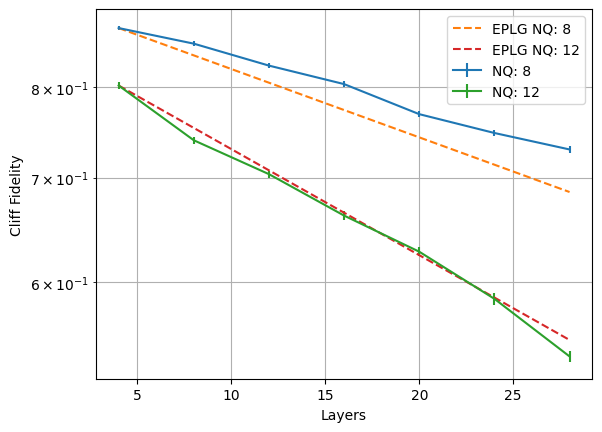

In [51]:
add_eplg = True

for nqi, nq in enumerate(nqubits):
    plt.errorbar(
        nlayers,
        [np.mean(cliff_res_lst[nqi][i]) for i in range(len(nlayers))],
        [
            np.std(cliff_res_lst[nqi][i]) / np.sqrt(ncliffordizations)
            for i in range(len(nlayers))
        ],
        label="NQ: %d" % nq,
    )

    if add_eplg:
        #eplg is normalized to the SPAM measured by the cliff circuit
        alpha = (1-5/4*eplg_lst[nqi])
        eplg_no_spam = (1-5/4*eplg_lst[nqi])**(np.array(nlayers)*(nq-1)/2.)
        plt.plot(nlayers, eplg_no_spam/eplg_no_spam[0]*np.mean(cliff_res_lst[nqi][0]), label="EPLG NQ: %d" % nq, linestyle='--')

plt.ylabel("Cliff Fidelity")
plt.xlabel("Layers")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")

In [52]:
# Analyze the XEB data with caution!
if run_xeb and analyze_xeb:
    # load the statevector simulator
    sim_statevector = AerSimulator(method="statevector")

    xeb_data = []  # xeb data
    xeb_data_norm = []  # normalized to the ideal value
    xeb_data_norm2 = []  # ideal value

    for nqi, nq in enumerate(nqubits):
        xeb_data_norm.append([])
        xeb_data.append([])
        xeb_data_norm2.append([])
        for nlind, nl in enumerate(nlayers):
            xeb_data_norm[-1].append([])
            xeb_data[-1].append([])
            xeb_data_norm2[-1].append([])

            # bind all the parameters
            # which will create haarsamples circuits
            haar_ideal_circ_list = haar_list[nqi][nlind].bindings.bind_all(
                haar_list[nqi][nlind].circuit
            )

            for j in range(len(haar_ideal_circ_list)):
                # save the statevector
                haar_ideal_circ_list[j].save_statevector()
                run1 = sim_statevector.run(haar_ideal_circ_list[j])

                p0, p0_ideal = cu.xeb(
                    nq,
                    haar_jobs[nqi].result()[nlind].data["meas"][j].get_counts(),
                    run1.result().get_statevector().probabilities_dict(),
                )
                xeb_data[-1][-1].append(p0)
                xeb_data_norm[-1][-1].append(p0 / p0_ideal)
                xeb_data_norm2[-1][-1].append(p0_ideal)

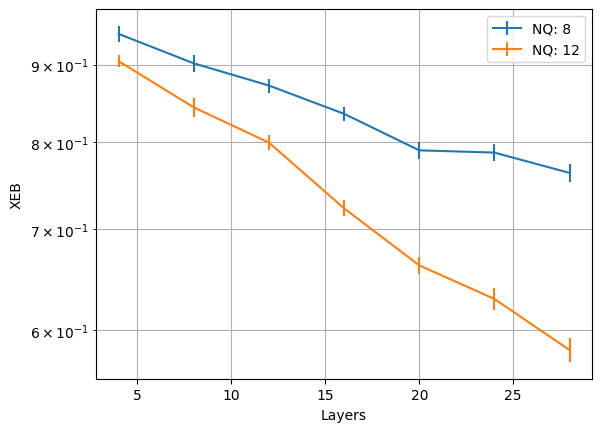

In [53]:
for nqi, nq in enumerate(nqubits):
    plt.errorbar(
        nlayers,
        [np.mean(xeb_data_norm[nqi][i]) for i in range(len(nlayers))],
        [
            np.std(xeb_data_norm[nqi][i]) / np.sqrt(haarsamples)
            for i in range(len(nlayers))
        ],
        label="NQ: %d" % nq,
    )

plt.ylabel("XEB")
plt.xlabel("Layers")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")

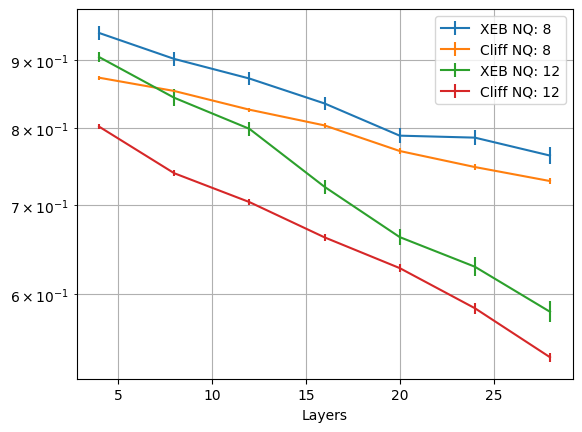

In [54]:
#plot both if both are analyzed

for nqi, nq in enumerate(nqubits):
    plt.errorbar(
        nlayers,
        [np.mean(xeb_data_norm[nqi][i]) for i in range(len(nlayers))],
        [
            np.std(xeb_data_norm[nqi][i]) / np.sqrt(haarsamples)
            for i in range(len(nlayers))
        ],
        label="XEB NQ: %d" % nq,
    )

    plt.errorbar(
        nlayers,
        [np.mean(cliff_res_lst[nqi][i]) for i in range(len(nlayers))],
        [
            np.std(cliff_res_lst[nqi][i]) / np.sqrt(ncliffordizations)
            for i in range(len(nlayers))
        ],
        label="Cliff NQ: %d" % nq,
    )

plt.ylabel("")
plt.xlabel("Layers")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")

# Copyright

In [26]:
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()